In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ========================
# CONFIG: Input Models
# ========================
model_files = [
    ("Model-1", "predictions/results.csv"),
    ("Model-2", "predictions_2/results.csv"),
    ("Model-3", "predictions_3/results.csv"),
    ("Model-4", "predictions_4/results.csv"),
    # Add more (label, filepath) tuples as needed
]


# Config

In [13]:
energy_range = (5, 8)
nbins = 180
title_params = {'fontsize': 24}
label_params = {'fontsize': 18}
tick_params = {'axis': 'both', 'direction': 'out', 'labelsize': 14}
legend_params = {'fontsize': 12}

hist_args_linear = {
    'range': (-1, 1),
    'bins': 121,
    'density': True,
    'histtype': 'step',
    'log': False,
    'linewidth': 2
}
hist_args_log = {
    'range': (-2, 2),
    'bins': 121,
    'density': True,
    'histtype': 'step',
    'log': True,
    'linewidth': 2
}

# Thresholds for summary stats
log_difference, reco_percent = 0.1, 15 

# Load

In [14]:
# Load all data
models = [(label, pd.read_csv(path)) for label, path in model_files]

# Pred vs True

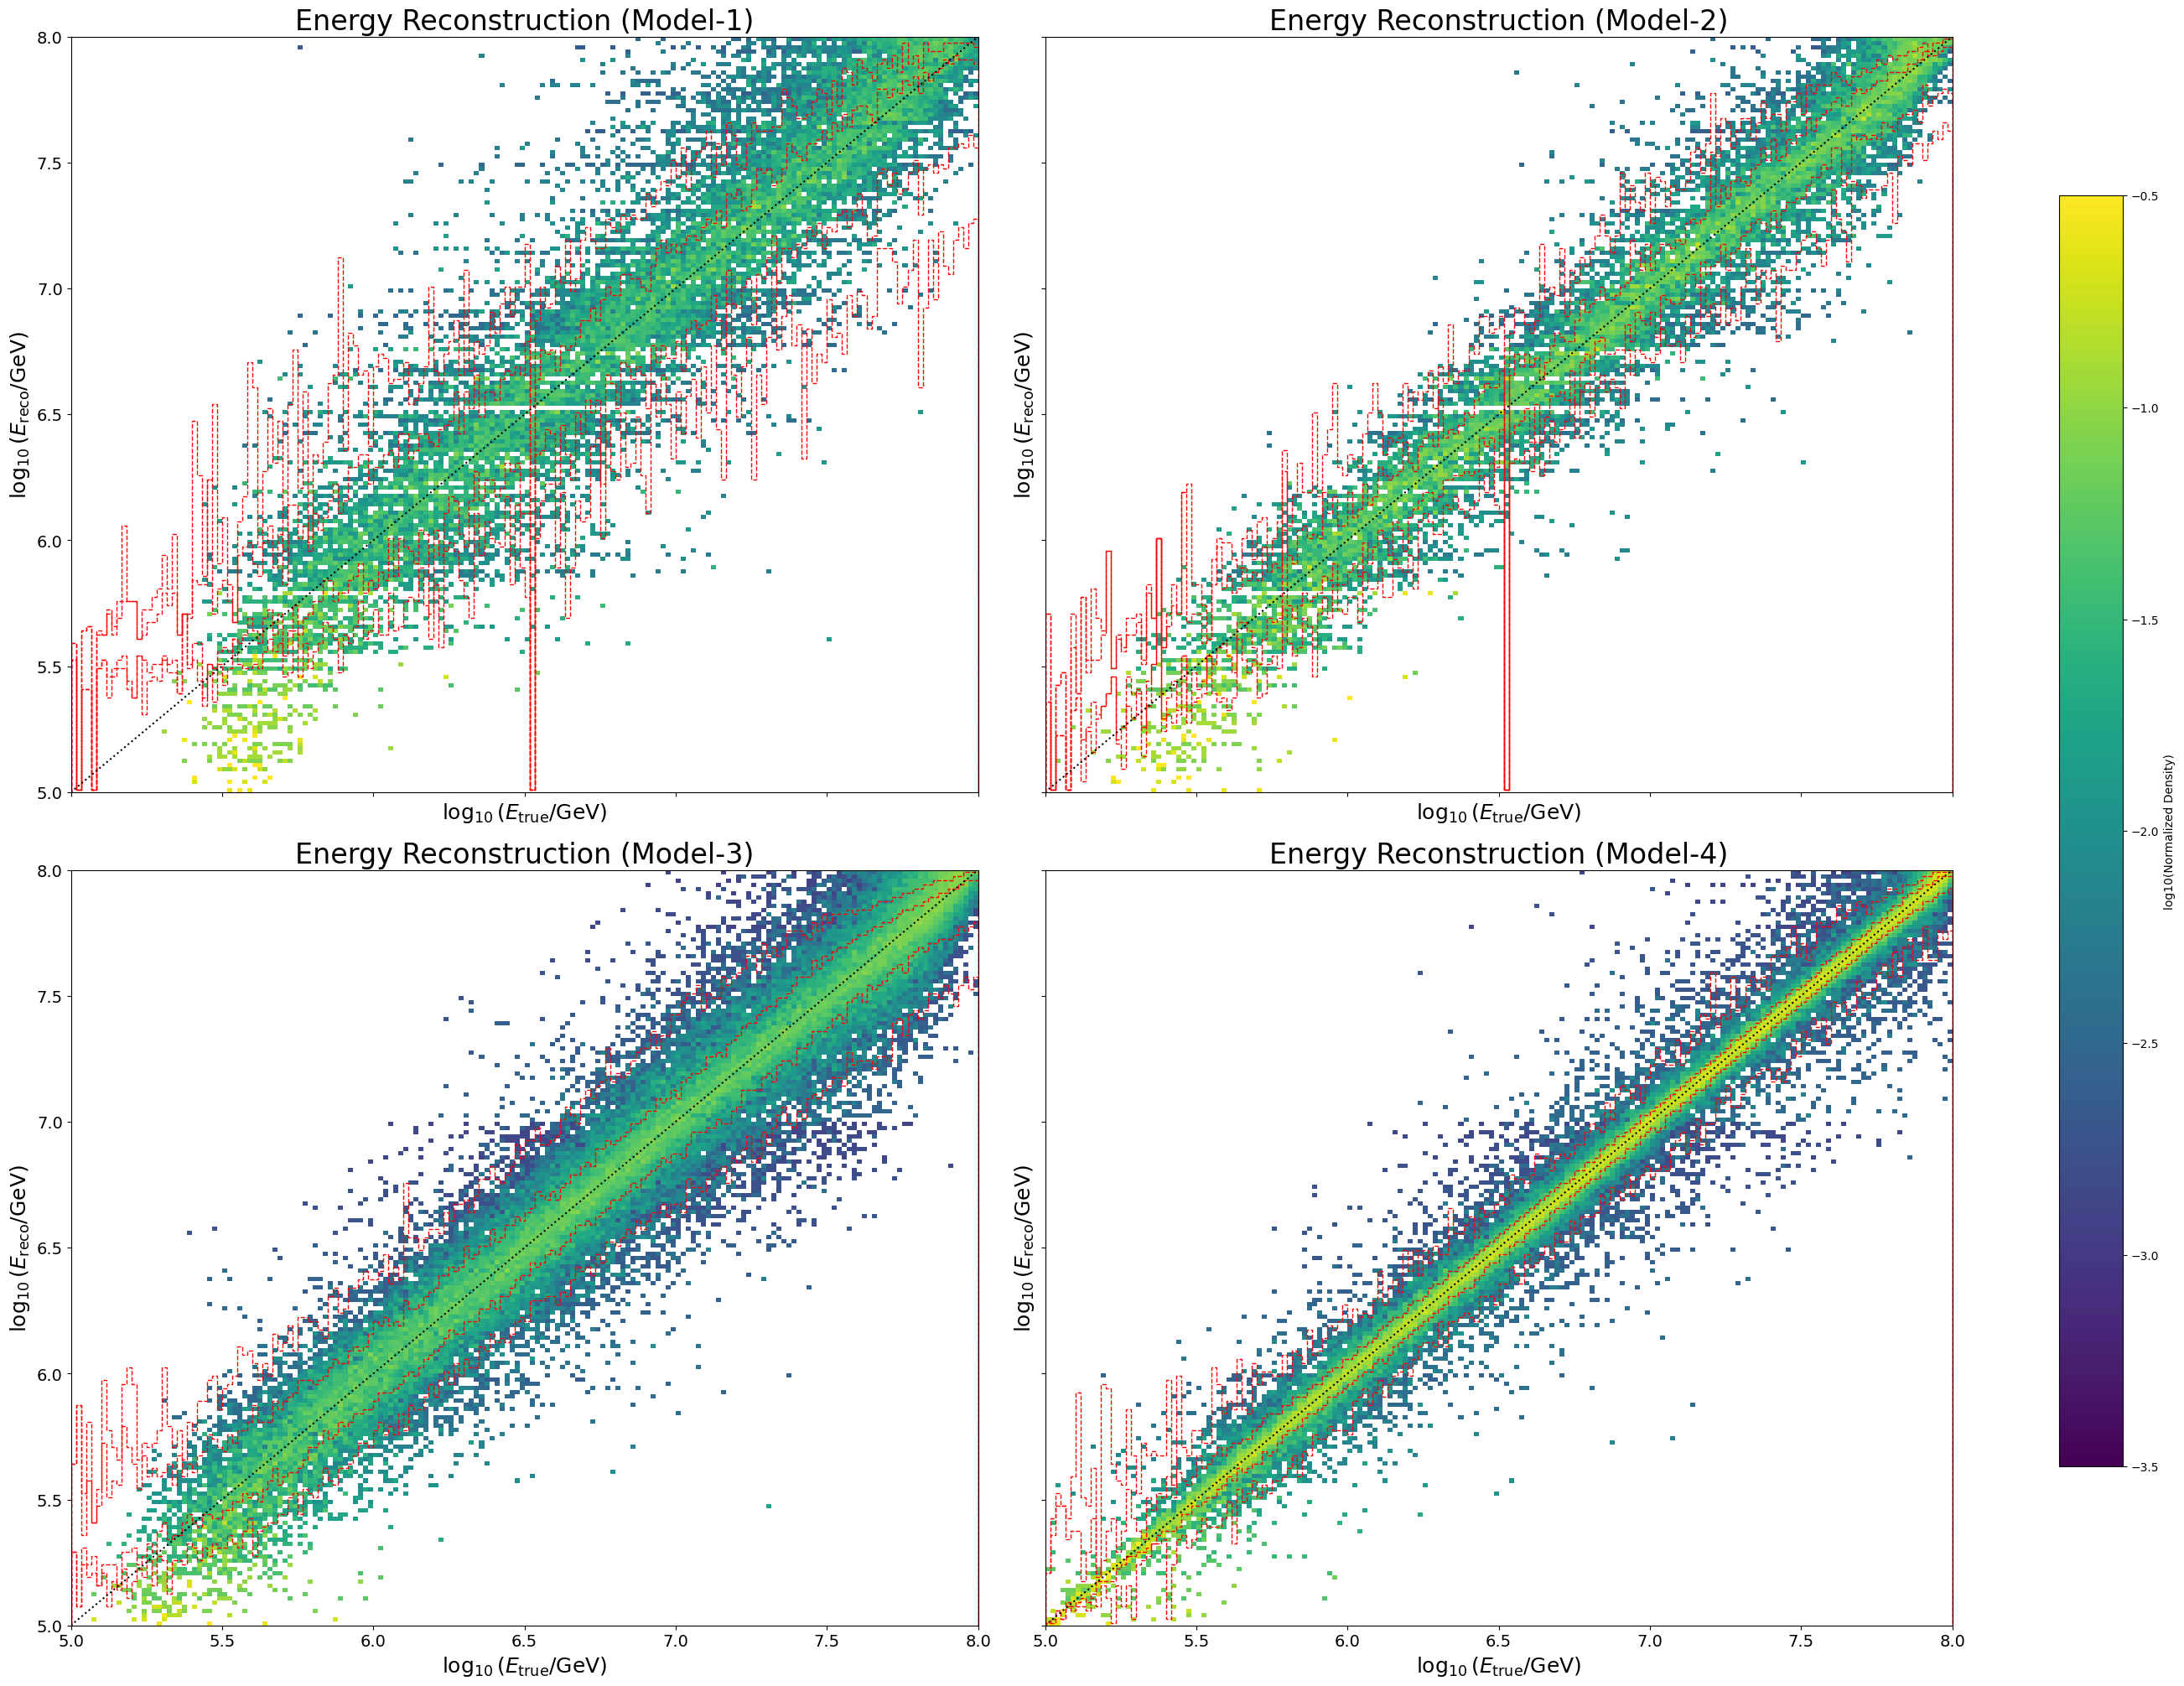

In [15]:
import math

# =====================================================
# 1. Energy Reconstruction Plots (Pred vs True per model)
# =====================================================
n_models = len(models)

# Arrange plots in 2 rows (or more if needed)
ncols = math.ceil(n_models / 2)
nrows = 2 if n_models > 1 else 1

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(13*ncols, 10*nrows),
    sharex=True, sharey=True,
    constrained_layout=True
)

# Flatten axes to make iterating easier
axes = np.atleast_1d(axes).ravel()

bin_edges = np.linspace(*energy_range, nbins+1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

for ax, (label, df) in zip(axes, models):
    # 2D histogram of (pred vs true)
    hist, xedges, yedges = np.histogram2d(
        df["energy_pred"], df["energy"],
        bins=(bin_edges, bin_edges)
    )

    # Normalize along true energy axis
    hist = np.divide(hist, np.sum(hist, axis=0),
                     out=np.zeros_like(hist), where=np.sum(hist, axis=0) != 0)

    # Plot
    with np.errstate(divide="ignore"):
        pcm = ax.pcolormesh(
            xedges, yedges, np.log10(hist.T),
            vmin=-3.5, vmax=-0.5, shading="auto", cmap="viridis"
        )

    # Diagonal = perfect reconstruction
    ax.plot(energy_range, energy_range, color="black", linestyle=":")

    # Contours
    contour_values = [.025, .16, .84, .975]
    contour_indices = np.asarray([
        np.searchsorted(np.cumsum(col), contour_values)
        for col in hist.T
    ]) % nbins
    for contour in contour_indices.T:
        ax.stairs(bin_centers[contour], edges=bin_edges,
                  color="red", linestyle="--")

    # Decorations
    ax.set_title(f"Energy Reconstruction ({label})", **title_params)
    ax.set_xlabel(r'$\log_{10}(E_{\mathrm{true}}/\mathrm{GeV})$', **label_params)
    ax.set_ylabel(r'$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$', **label_params)
    ax.tick_params(**tick_params)

    # Force correct axis range
    ax.set_xlim(energy_range)
    ax.set_ylim(energy_range)

# Hide unused axes if models < nrows*ncols
for ax in axes[len(models):]:
    ax.axis("off")

# Shared colorbar
fig.colorbar(pcm, ax=axes, shrink=0.8, label="log10(Normalized Density)")
plt.show()


# Resolution Histograms

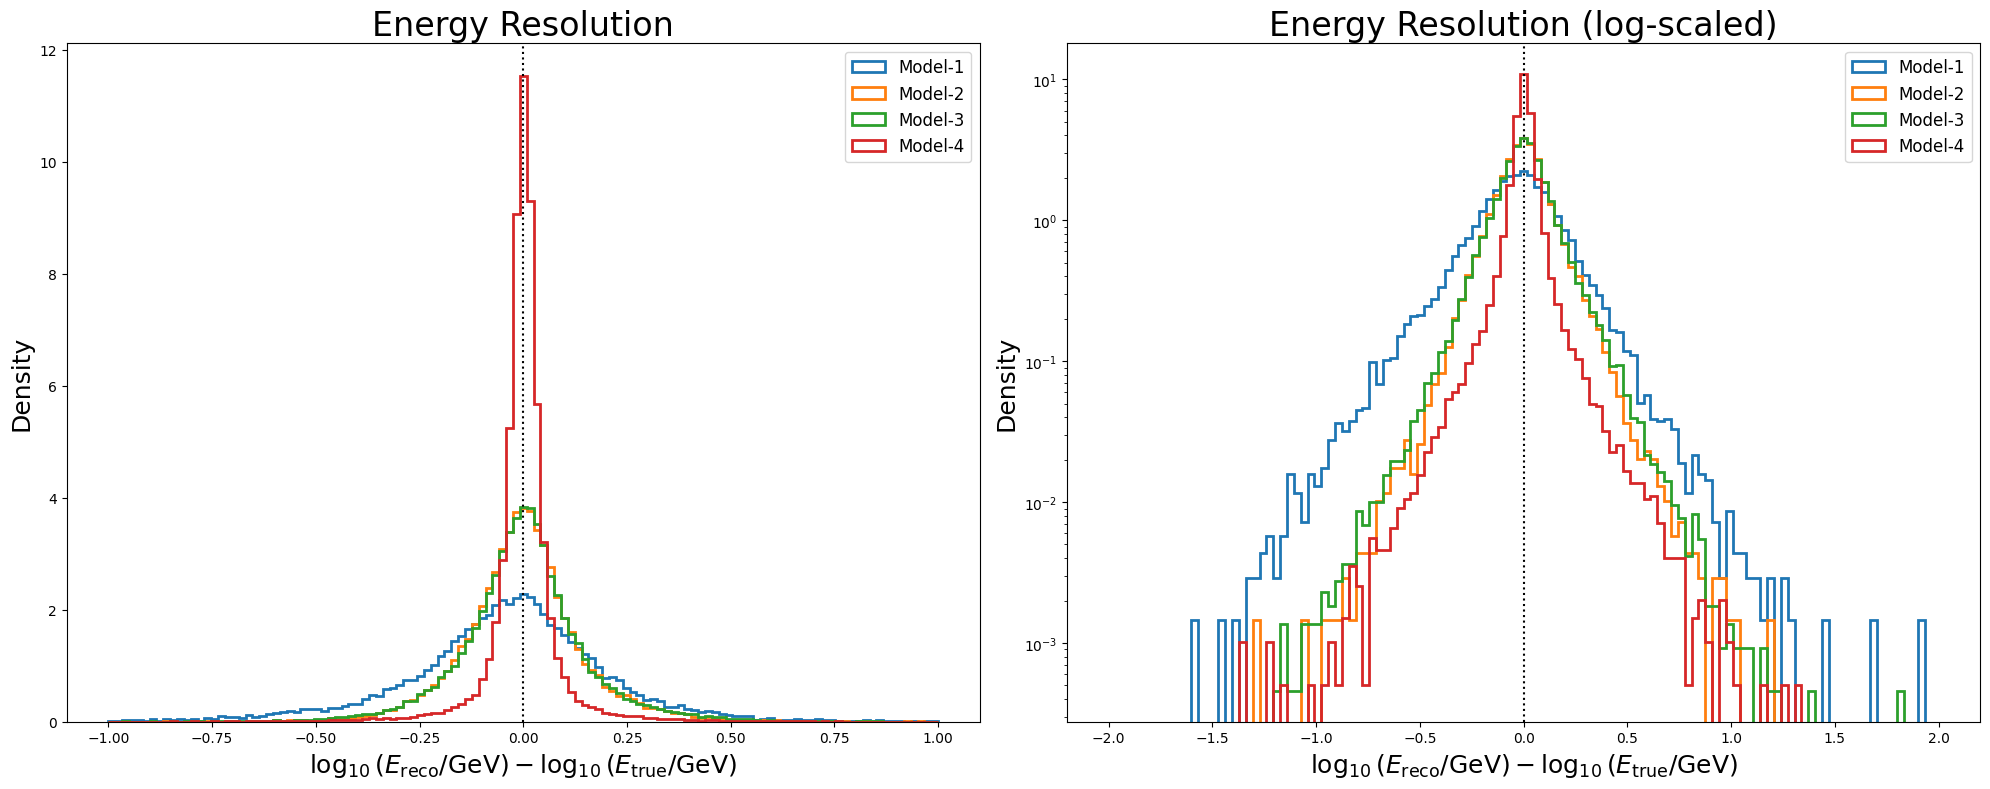

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

for label, df in models:
    resolution = df["energy_pred"] - df["energy"]
    
    axes[0].hist(resolution, label=label, **hist_args_linear)
    axes[1].hist(resolution, label=label, **hist_args_log)

for ax, title in zip(axes, ["Energy Resolution", "Energy Resolution (log-scaled)"]):
    ax.axvline(0, color="black", linestyle=":")
    ax.set_title(title, **title_params)
    ax.set_xlabel(r'$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV}) - \log_{10}(E_{\mathrm{true}}/\mathrm{GeV})$', **label_params)
    ax.set_ylabel("Density", **label_params)
    ax.legend(**legend_params)

plt.tight_layout()
plt.show()

# Summary Statistics

In [17]:
for label, df in models:
    diff = df["energy_pred"] - df["energy"]
    
    true_energy = 10**df["energy"]
    reco_energy = 10**df["energy_pred"]
    true_diff = reco_energy - true_energy
    percent_diff = 100 * true_diff / true_energy
    
    std_dev_lo, median, std_dev_hi = np.percentile(diff, (16, 50, 84))
    diff_percentage = 100 * np.mean(np.abs(diff) <= log_difference)
    percent_diff_percentage = 100 * np.mean(np.abs(percent_diff) <= reco_percent)
    
    print(f"\nStats for {label}:")
    print(f'  Energy resolution: {median:.3f} (+{std_dev_hi:.3f}, {std_dev_lo:.3f})')
    print(f'  |log diff| ≤ {log_difference}: {diff_percentage:.2f}% of events')
    print(f'  |percent diff| ≤ {reco_percent}%: {percent_diff_percentage:.2f}% of events')


Stats for Model-1:
  Energy resolution: -0.029 (+0.165, -0.244)
  |log diff| ≤ 0.1: 40.06% of events
  |percent diff| ≤ 15%: 27.77% of events

Stats for Model-2:
  Energy resolution: -0.002 (+0.116, -0.125)
  |log diff| ≤ 0.1: 60.66% of events
  |percent diff| ≤ 15%: 44.59% of events

Stats for Model-3:
  Energy resolution: -0.000 (+0.122, -0.125)
  |log diff| ≤ 0.1: 60.13% of events
  |percent diff| ≤ 15%: 44.47% of events

Stats for Model-4:
  Energy resolution: 0.001 (+0.043, -0.041)
  |log diff| ≤ 0.1: 88.92% of events
  |percent diff| ≤ 15%: 80.66% of events
